# Data Validation of Downtown Bluetooth Readings

## Directional Mismatch
Replication of @radumas earlier analysis of directional mismatch on the Gardiner. 

In [2]:
%matplotlib inline
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.sql as pandasql
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [3]:
# setting up pgsql connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [4]:
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional')
direction_obs = pandasql.read_sql(sql, con)

NOTE: Oneway streets are ommitted from the `ryu4.aggr_bt_directional` table. Values produced by the chart are from the entirety of September and October

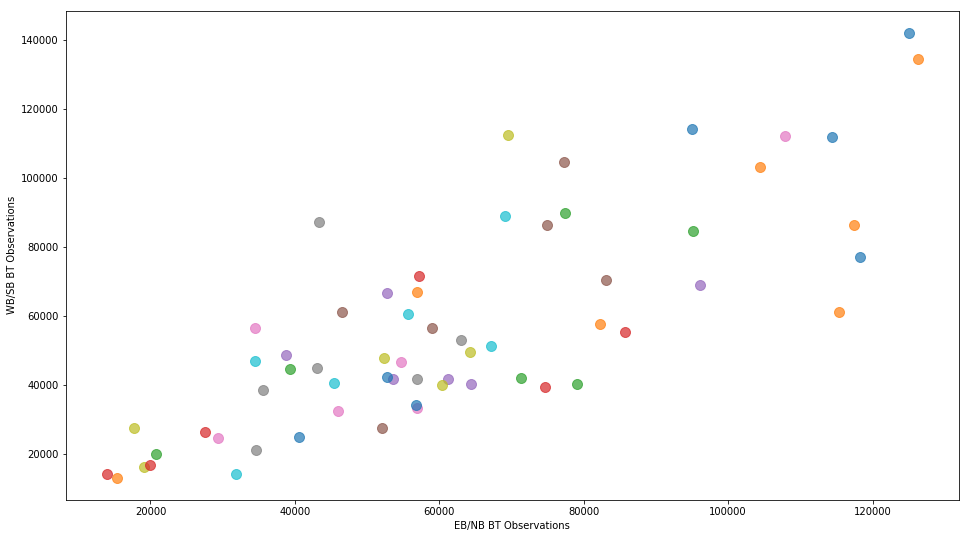

In [5]:
groups = direction_obs.groupby('sb_wb_report_name')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (sb_wb_report_name, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=sb_wb_report_name, linestyle='')

The scatterplot shows WB/SB observations of a route compared to their repsective EB/NB BT observations. As you can see, a few of the routes aren't 1:1.

In [6]:
sql = '''SELECT sb_wb_report_name AS "EB/NB Route Name", \
        nb_eb_report_name AS "WB/SB Route Name", \
        eb_nb_obs AS "Number EB/NB obs", \
        wb_sb_obs AS "Number WB/SB obs", \
        eb_nb_obs / wb_sb_obs AS "EB/WB NB/SB Ratio" \
        FROM ryu4.aggr_bt_directional
        ORDER BY "EB/WB NB/SB Ratio";'''
print_table(sql, con)

EB/NB Route Name,WB/SB Route Name,Number EB/NB obs,Number WB/SB obs,EB/WB NB/SB Ratio
DT-0110. University-SB_Dundas-to-Queen,DT-0117. University-NB_Queen-to-Dundas,43325.0,87236.0,0.496641
DT-0109. University-SB_College-to-Dundas,DT-0118. University-NB_Dundas-to-College,34472.0,56424.0,0.610946
DT-0111. University-SB_Queen-to-King,DT-0116. University-NB_King-to-Queen,69504.0,112529.0,0.617654
DT-0058. King-WB_Broadview-to-Parliament,DT-0057. King-EB_Parliament-to-Broadview,17657.0,27489.0,0.642330
DT-0028. Queen-WB_Broadview-to-Parliament,DT-0027. Queen-EB_Parliament-to-Broadview,34473.0,46797.0,0.736650
DT-0104. Spadina-SB_Front-to-Bremner,DT-0105. Spadina-NB_Bremner-to-Front,77243.0,104574.0,0.738644
DT-0126. Jarvis-SB_Queen-to-King,DT-0129. Jarvis-NB_King-to-Queen,46544.0,61229.0,0.760163
DT-0112. University-SB_King-to-Front,DT-0115. University-NB_Front-to-King,69135.0,88838.0,0.778214
DT-0125. Jarvis-SB_Dundas-to-Queen,DT-0130. Jarvis-NB_Queen-to-Dundas,52718.0,66603.0,0.791526
DT-0103. Spadina-SB_King-to-Front,DT-0106. Spadina-NB_Front-to-King,38796.0,48744.0,0.795913


The chart above shows each route's EB/NB and WB/SB observation counts for Sept-Oct in addition to EB/NB-WB/SB observations. All route observations are not 1:1 with both directions which is expected. However, these differences are fairly high for both directions and there are many factors which may be influencing them. Lowering the range and taking data that is more recent may produce better results.

In [7]:
# select one week of data between '2017-10-27 00:00:00' and '2017-11-01 00:00:00'
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional_oneweek')
direction_obs_oneweek = pandasql.read_sql(sql, con)

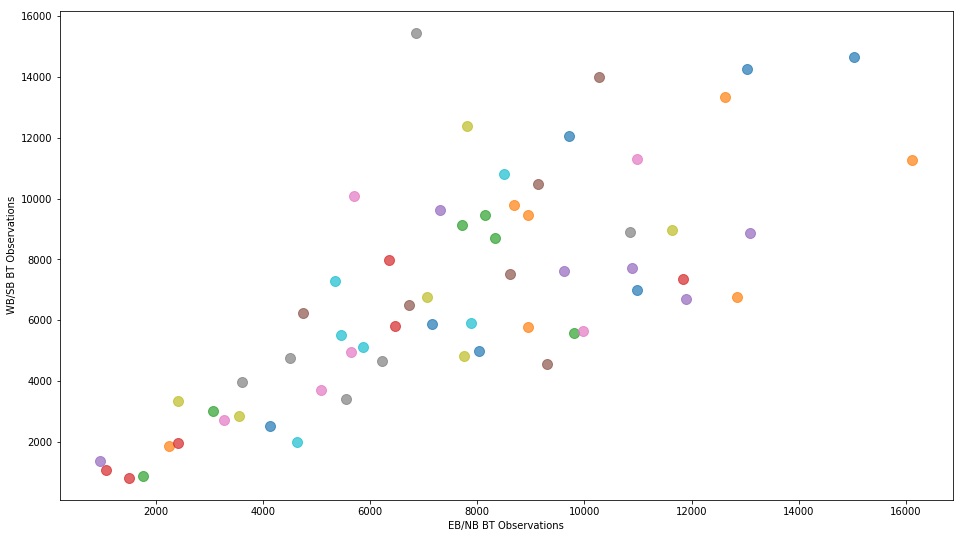

In [8]:
groups = direction_obs_oneweek.groupby('sb_wb_report_name')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (sb_wb_report_name, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=sb_wb_report_name, linestyle='')

Not much has changed between the 2-month interval graph and the 1-week interval graph. Since not much has changed, a focus is given on the top/bottom routes with largest difference between EB/NB and WB/SB.

In [9]:
sql = '''SELECT sb_wb_report_name AS "EB/NB Route Name", \
        nb_eb_report_name AS "WB/SB Route Name", \
        eb_nb_obs AS "Number EB/NB obs", \
        wb_sb_obs AS "Number WB/SB obs", \
        eb_nb_obs - wb_sb_obs AS "EB/NB-WB/SB" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY "EB/NB-WB/SB"
        LIMIT 10;'''
print_table(sql, con)

EB/NB Route Name,WB/SB Route Name,Number EB/NB obs,Number WB/SB obs,EB/NB-WB/SB
DT-0110. University-SB_Dundas-to-Queen,DT-0117. University-NB_Queen-to-Dundas,6861.0,15451.0,-8590.0
DT-0111. University-SB_Queen-to-King,DT-0116. University-NB_King-to-Queen,7799.0,12377.0,-4578.0
DT-0109. University-SB_College-to-Dundas,DT-0118. University-NB_Dundas-to-College,5704.0,10083.0,-4379.0
DT-0104. Spadina-SB_Front-to-Bremner,DT-0105. Spadina-NB_Bremner-to-Front,10265.0,14000.0,-3735.0
DT-0029. Queen-WB_Parliament-to-Jarvis,DT-0026. Queen-EB_Jarvis-to-Parliament,9718.0,12067.0,-2349.0
DT-0125. Jarvis-SB_Dundas-to-Queen,DT-0130. Jarvis-NB_Queen-to-Dundas,7308.0,9632.0,-2324.0
DT-0112. University-SB_King-to-Front,DT-0115. University-NB_Front-to-King,8496.0,10807.0,-2311.0
DT-0028. Queen-WB_Broadview-to-Parliament,DT-0027. Queen-EB_Parliament-to-Broadview,5344.0,7284.0,-1940.0
DT-0121. Yonge-SB_King-to-Front,DT-0122. Yonge-NB_Front-to-King,6357.0,7967.0,-1610.0
DT-0126. Jarvis-SB_Queen-to-King,DT-0129. Jarvis-NB_King-to-Queen,4746.0,6226.0,-1480.0


In [8]:
sql = '''SELECT sb_wb_report_name AS "wbsb_route", \
        nb_eb_report_name AS "ebnb_route" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY eb_nb_obs - wb_sb_obs
        LIMIT 10;'''
top_routes = pandasql.read_sql(sql, con)
top_ebnb = top_routes.ebnb_route
top_wbsb = top_routes.wbsb_route

DT-0117. University-NB_Queen-to-Dundas / DT-0110. University-SB_Dundas-to-Queen


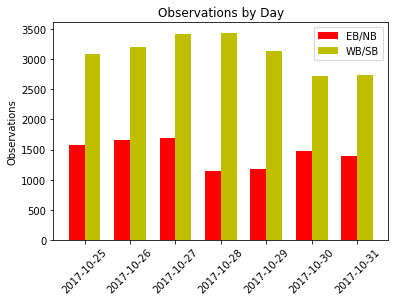

DT-0116. University-NB_King-to-Queen / DT-0111. University-SB_Queen-to-King


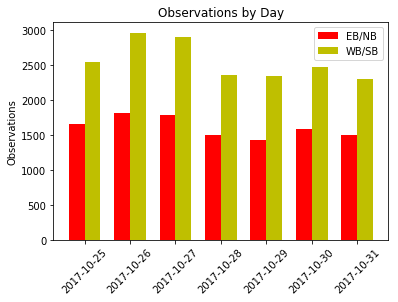

DT-0118. University-NB_Dundas-to-College / DT-0109. University-SB_College-to-Dundas


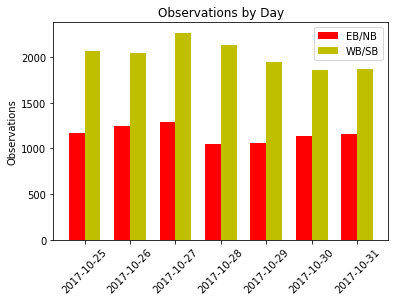

DT-0105. Spadina-NB_Bremner-to-Front / DT-0104. Spadina-SB_Front-to-Bremner


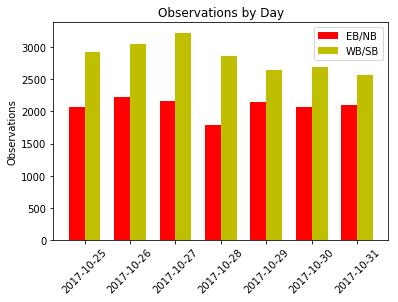

DT-0026. Queen-EB_Jarvis-to-Parliament / DT-0029. Queen-WB_Parliament-to-Jarvis


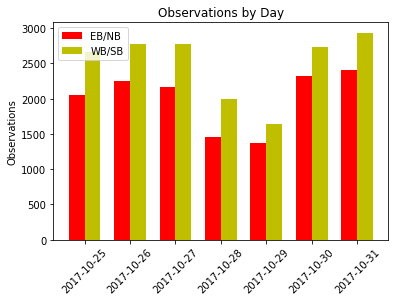

DT-0115. University-NB_Front-to-King / DT-0112. University-SB_King-to-Front


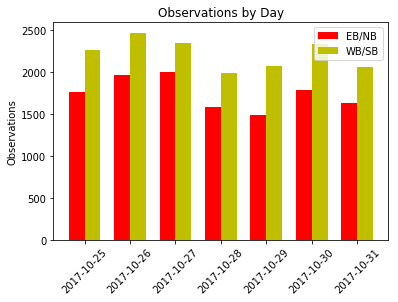

DT-0027. Queen-EB_Parliament-to-Broadview / DT-0028. Queen-WB_Broadview-to-Parliament


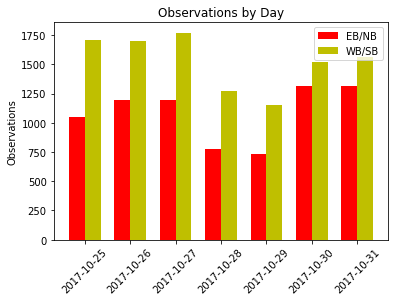

DT-0130. Jarvis-NB_Queen-to-Dundas / DT-0125. Jarvis-SB_Dundas-to-Queen


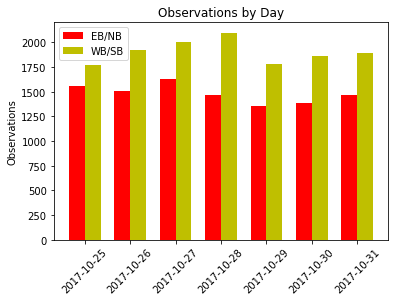

DT-0122. Yonge-NB_Front-to-King / DT-0121. Yonge-SB_King-to-Front


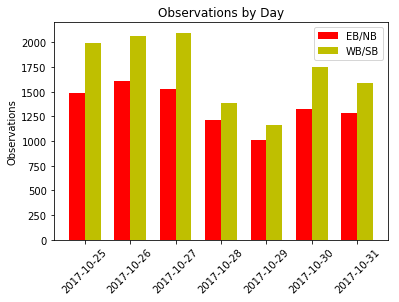

DT-0123. Yonge-NB_King-to-Queen / DT-0120. Yonge-SB_Queen-to-King


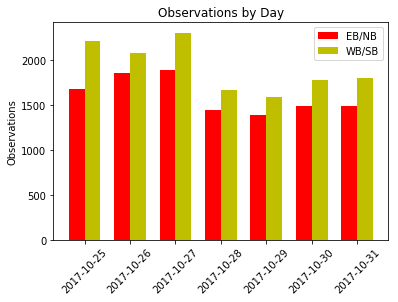

In [22]:
for i in range(len(top_routes)):
    print(top_ebnb[i] + " / " + top_wbsb[i])
    sql = pg.SQL('''SELECT eb_nb_obs, wb_sb_obs, date_bin \
            FROM ryu4.aggr_bt_directional_day \
            WHERE nb_eb_report_name = {ebnb_route} AND sb_wb_report_name = {wbsb_route}
            ORDER BY date_bin''').format(ebnb_route = pg.Literal(top_ebnb[i]), wbsb_route = pg.Literal(top_wbsb[i]))
    route_obs_day = pandasql.read_sql(sql, con)
    fig, ax = plt.subplots()
    N = len(route_obs_day)
    ind = np.arange(N)
    width = 0.35
    ebnb_rects = ax.bar(ind, route_obs_day.eb_nb_obs, width, color='r')
    wbsb_rects = ax.bar(ind + width, route_obs_day.wb_sb_obs, width, color='y')
    ax.set_ylabel('Observations')
    ax.set_title('Observations by Day')
    ax.set_xticks(ind + width / 2)
    plt.xticks(rotation=45)
    ax.set_xticklabels(route_obs_day.date_bin)
    ax.legend((ebnb_rects[0], wbsb_rects[0]), ('EB/NB', 'WB/SB'))
    plt.show()

Bottom 10

DT-0117. University-NB_Queen-to-Dundas / DT-0110. University-SB_Dundas-to-Queen


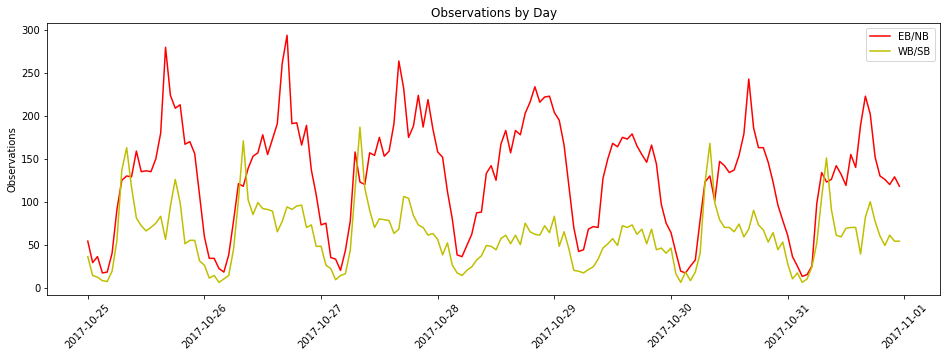

DT-0116. University-NB_King-to-Queen / DT-0111. University-SB_Queen-to-King


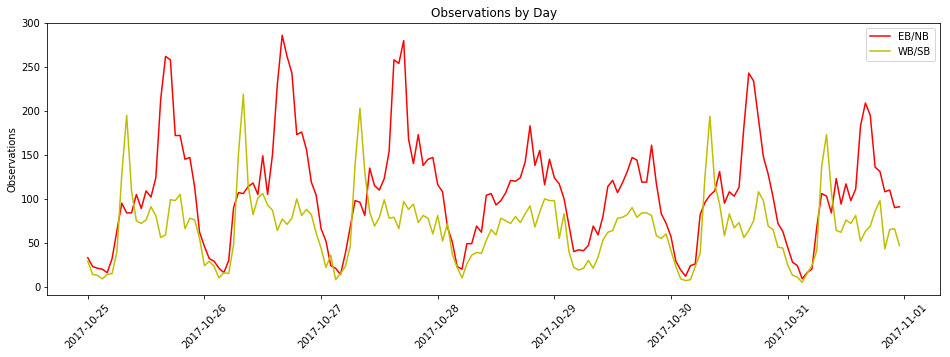

DT-0118. University-NB_Dundas-to-College / DT-0109. University-SB_College-to-Dundas


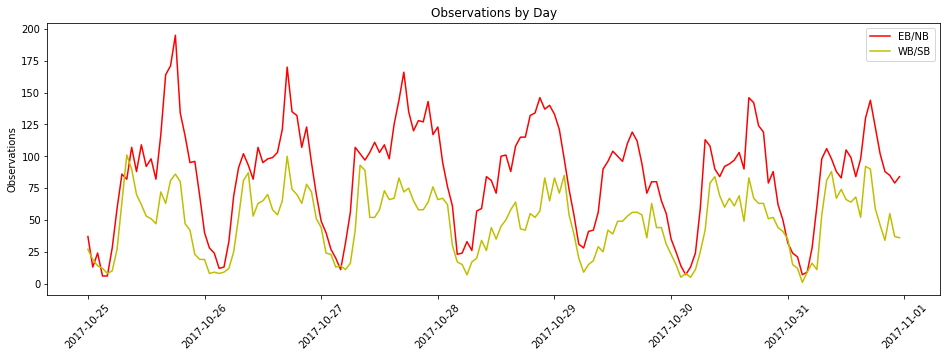

DT-0105. Spadina-NB_Bremner-to-Front / DT-0104. Spadina-SB_Front-to-Bremner


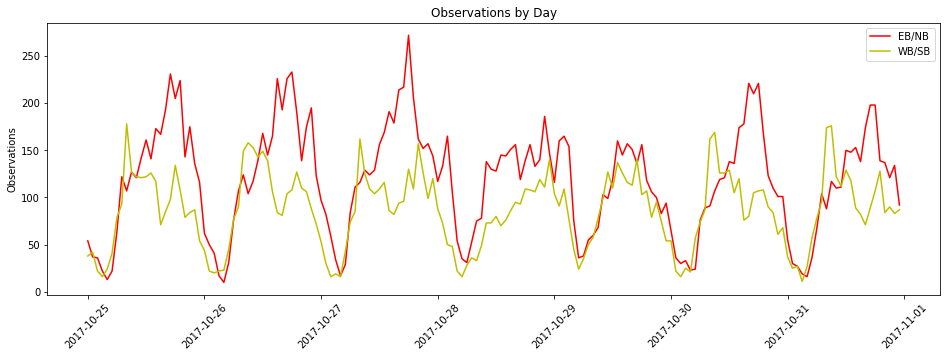

DT-0026. Queen-EB_Jarvis-to-Parliament / DT-0029. Queen-WB_Parliament-to-Jarvis


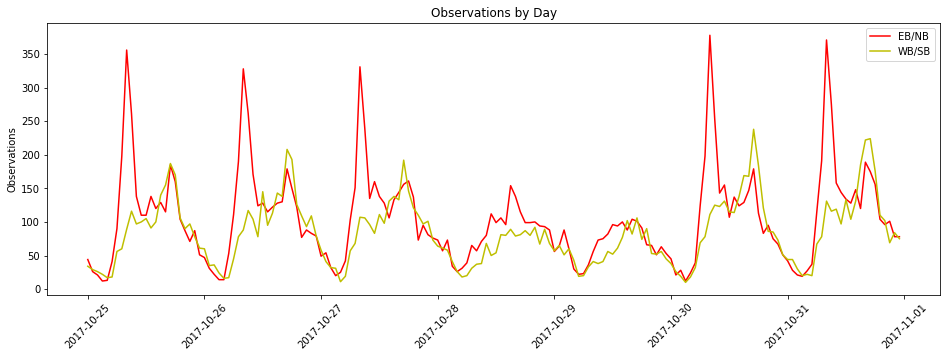

DT-0115. University-NB_Front-to-King / DT-0112. University-SB_King-to-Front


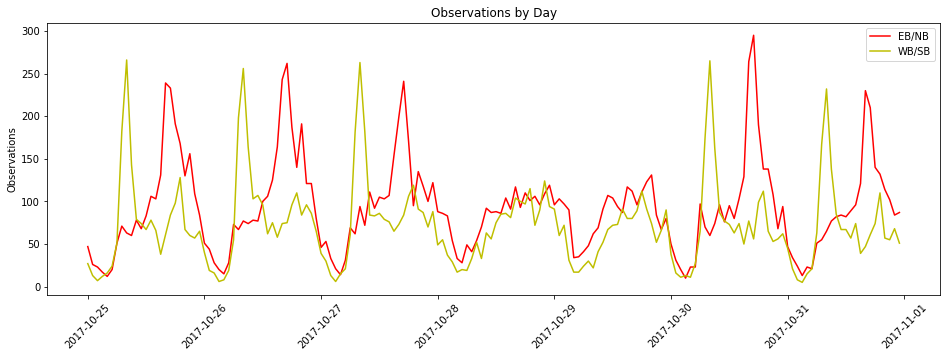

DT-0027. Queen-EB_Parliament-to-Broadview / DT-0028. Queen-WB_Broadview-to-Parliament


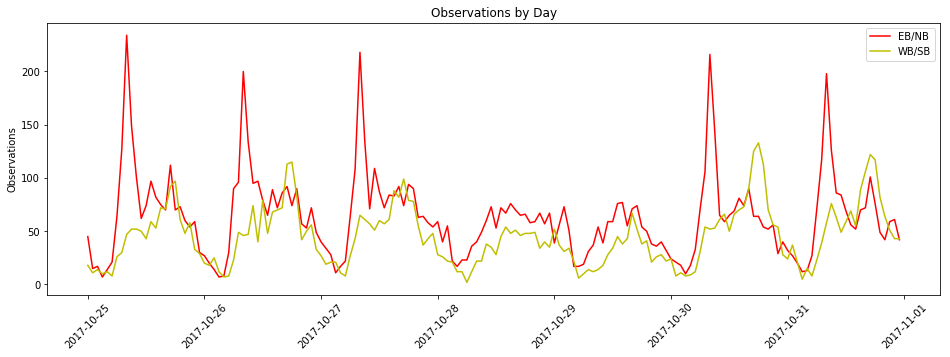

DT-0130. Jarvis-NB_Queen-to-Dundas / DT-0125. Jarvis-SB_Dundas-to-Queen


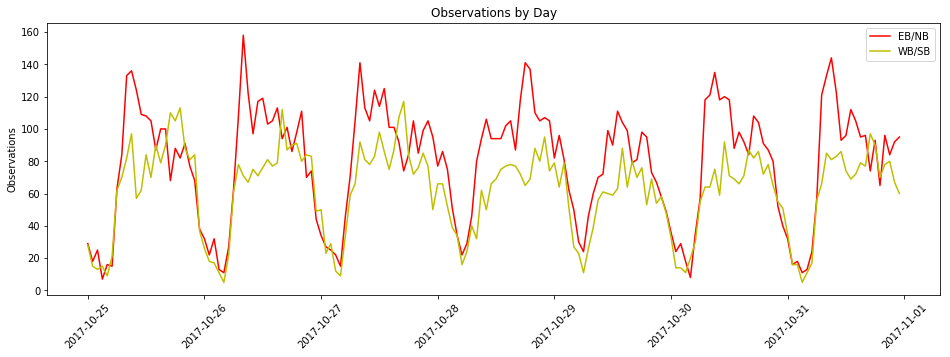

DT-0122. Yonge-NB_Front-to-King / DT-0121. Yonge-SB_King-to-Front


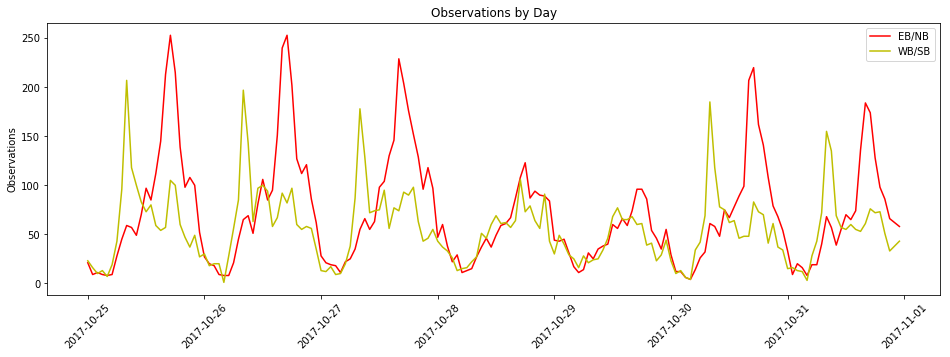

DT-0123. Yonge-NB_King-to-Queen / DT-0120. Yonge-SB_Queen-to-King


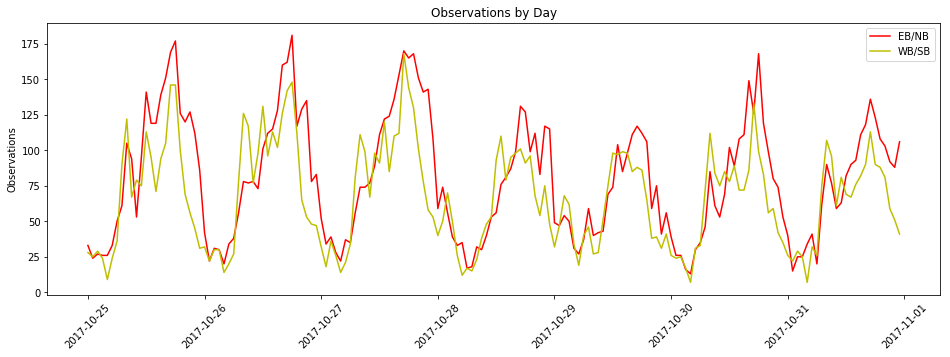

In [17]:
for i in range(len(top_routes)):
    print(top_ebnb[i] + " / " + top_wbsb[i])
    sql = pg.SQL('''CREATE OR REPLACE TEMP VIEW wbsb AS \
                    SELECT DATE_TRUNC('hour', datetime_bin) datetime_bin, SUM(obs) obs \
                    FROM aggr_5min_bt \
                    WHERE report_name = {ebnb_route} \
                    AND datetime_bin < '2017-11-01' AND datetime_bin >= '2017-10-25' \
                    GROUP BY report_name, DATE_TRUNC('hour', datetime_bin); \
                    CREATE OR REPLACE TEMP VIEW ebnb AS \
                    SELECT DATE_TRUNC('hour', datetime_bin) datetime_bin, SUM(obs) obs \
                    FROM aggr_5min_bt \
                    WHERE report_name = {wbsb_route} \
                    AND datetime_bin < '2017-11-01' AND datetime_bin >= '2017-10-25' \
                    GROUP BY report_name, DATE_TRUNC('hour', datetime_bin); \
                    SELECT wbsb.datetime_bin datetime_bin, wbsb.obs wbsb_obs, ebnb.obs ebnb_obs \
                    FROM wbsb \
                    INNER JOIN ebnb ON wbsb.datetime_bin = ebnb.datetime_bin \
                    ORDER BY datetime_bin;
        ''').format(ebnb_route = pg.Literal(top_ebnb[i]), wbsb_route = pg.Literal(top_wbsb[i]))
    route_obs = pandasql.read_sql(sql, con)
    fig, ax = plt.subplots(1, 1, figsize=(16,5))
    width = 0.35
    ebnb_line = ax.plot(route_obs.datetime_bin, route_obs.ebnb_obs, color='r')
    wbsb_line = ax.plot(route_obs.datetime_bin, route_obs.wbsb_obs, color='y')
    ax.set_ylabel('Observations')
    ax.set_title('Observations by Day')
    plt.xticks(rotation=45)
    ax.legend((ebnb_line[0], wbsb_line[0]), ('EB/NB', 'WB/SB'))
    plt.show()

Top 10